In [5]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 

wine_df = pd.read_csv("wine_data.csv")
chickwts_df = pd.read_csv("chickwts_data.csv")
arrests_df = pd.read_csv("arrests_data.csv")

print("Wine missing:\n", wine_df.isnull().sum())
print("\nChickwts missing:\n", chickwts_df.isnull().sum())
print("\nUSArrests missing:\n", arrests_df.isnull().sum())

scaler = StandardScaler()

wine_features = wine_df.drop("target", axis=1)
wine_scaled = scaler.fit_transform(wine_features)

chickwts_features = chickwts_df.drop("feed_name", axis=1)
chickwts_scaled = scaler.fit_transform(chickwts_features)

arrests_features = arrests_df.drop("Unnamed: 0", axis=1)
arrests_scaled = scaler.fit_transform(arrests_features)

print("\nWine shape:", wine_df.shape)
print("Chickwts shape:", chickwts_df.shape)
print("USArrests shape:", arrests_df.shape)

Wine missing:
 alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

Chickwts missing:
 feed_name              0
proteinContent         0
fatContent             0
fiberContent           0
calciumContent         0
phosphorusContent      0
moistureContent        0
ashContent             0
metabolizableEnergy    0
lysineContent          0
methionineContent      0
particleSize           0
density                0
price                  0
shelfLife              0
weight                 0
dtype: int64

USArrests missing:
 Unnamed: 0    0
Murder        0
Assault   

In [ ]:
#step 2 - wine

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X = wine_scaled 
y = wine_df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

#95% variance 
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of components chosen:", pca.n_components_)

#GridSearchCV for best k + metric 

from sklearn.metrics import classification_report

param_grid = {
    'n_neighbors': list(range(1, 21)),
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_pca, y_train)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report: \n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy)

Number of components chosen: 10
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 18}

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Accuracy: 1.0


In [ ]:
#step 3 - chicks

from sklearn.metrics.pairwise import cosine_similarity

#only need to use the weight column for c data 

weights = chickwts_df[['weight']].values 
weights_scaled = scaler.fit_transform(weights) 

pca = PCA(n_components=1)
weights_pca = pca.fit_transform(weights_scaled)

feed_weights = pd.DataFrame(weights_pca, columns=['PC1'])
feed_weights["feed_name"] = chickwts_df["feed_name"]
feed_avg = feed_weights.groupby("feed_name").mean()

similarity_matrix = cosine_similarity(feed_avg)

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=feed_avg.index,
    columns=feed_avg.index
)

print("Similarity Matrix: \n", similarity_df)

def recommend_feed(feed, top_n=3):
    scores = similarity_df[feed].sort_values(ascending=False)
    return scores.iloc[1:top_n+1]

print("\nRecommendations for '':\n", recommend_feed("ChickStart Plus"))



Similarity Matrix: 
 feed_name                BabyBirdBlend  BreederAdvance Complete  \
feed_name                                                         
BabyBirdBlend                      1.0                      1.0   
BreederAdvance Complete            1.0                      1.0   
BreederChoice Complete             1.0                      1.0   
BreederElite Complete              1.0                      1.0   
BreederOptimal Formula             1.0                      1.0   
...                                ...                      ...   
ShellStrength Pro                 -1.0                     -1.0   
StartRight Formula                 1.0                      1.0   
TeenChick Formula                  1.0                      1.0   
WeightGain Pro                     1.0                      1.0   
YolkPerfect Premium                1.0                      1.0   

feed_name                BreederChoice Complete  BreederElite Complete  \
feed_name                        

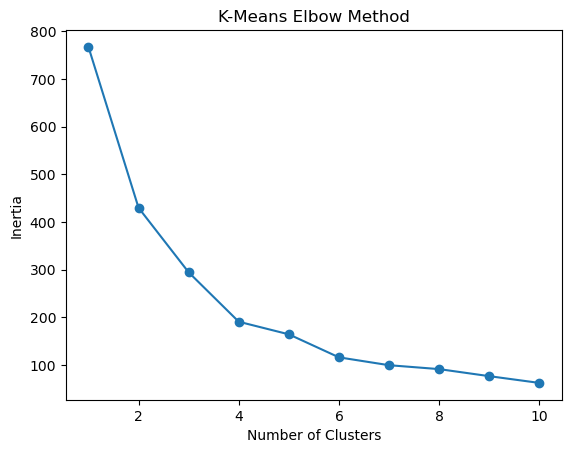

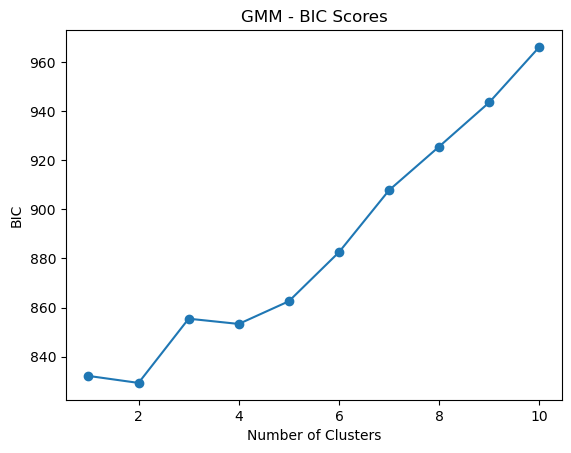

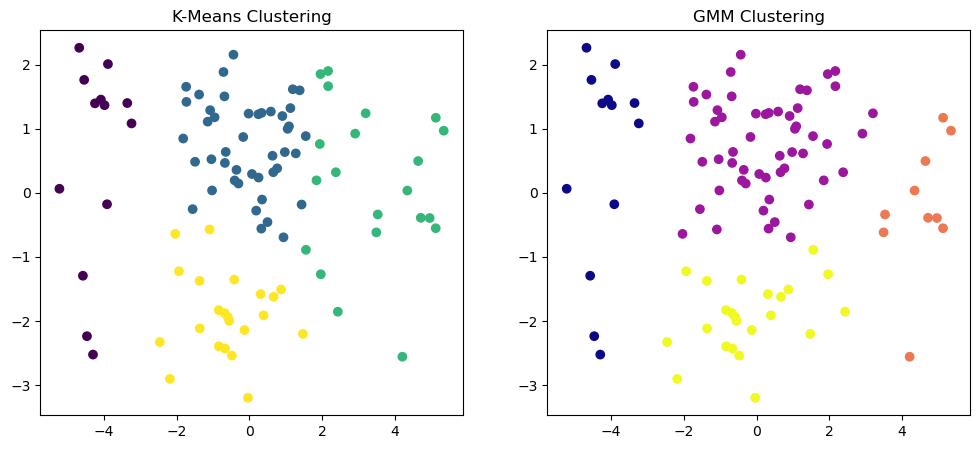

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Use chickwts_scaled for clustering

pca_vis = PCA(n_components=2)
X_pca = pca_vis.fit_transform(chickwts_scaled)

# KMeans elbow
K_range = range(1, 11)
inertia = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(list(K_range), inertia, marker="o")
plt.title("K-Means Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# KMeans 
kmeans = KMeans(n_clusters=4, random_state=42)
k_labels = kmeans.fit_predict(X_pca)

# GMM BIC 
bics = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_pca)
    bics.append(gmm.bic(X_pca))

plt.plot(range(1, 11), bics, marker="o")
plt.title("GMM - BIC Scores")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.show()

# GMM 
gmm = GaussianMixture(n_components=4, random_state=42)
g_labels = gmm.fit_predict(X_pca)

# Plot 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=k_labels, cmap="viridis")
axes[0].set_title("K-Means Clustering")

axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=g_labels, cmap="plasma")
axes[1].set_title("GMM Clustering")

plt.show()

# Explanations for how and what I used: 


# Step 1: Dataset Preparation 

#For this lab, three datasets were used: Wine, Arrests, and Chicken Weight
# 1. Missing Values Check  
    #None of the datasets contained missing values. 

#2. Data Standarization 
    #All numerical features were standardized using `StandardScaler`.  
    #This ensures each feature contributes equally to PCA and model performance (mean = 0, variance = 1) 

# Step 2: k-Nearest Neighbors (k-NN) Classification for the Wine Dataset

#1. PCA 
   # I used PCA to the standardized dataset while retaining 95% variance   
   #This reduced the dataset from 13 features to 10 key components 

#2. Tuning for Hyperparameters 
   #GridSearchCV was used to systematically test different values of *k* (neighbors) and distance metrics.  
   #The best model was found with:  
     #n_neighbors = 18
     #metric = euclidean  

#3. Model Evaluation 
   #The tuned k-NN model achieved 100% accuracy on the test set 
   #the Classification report shows perfect precision, recall, and F1-score across all three wine classes 

  # Step 3: Recommendation System for Chicken Weight Data 

# 1.Data Preparation
   #Only the `weight` feature was used as the performance indicator
   #The data was standardized to make sure their was uniform scaling

# 2. Dimensionality Reduction
   # I used PCA to reduce the standardized data to 1 principal component

#3. Cosine Similarity
   # Cosine similarity scores were calculated between average feed profiles and a similarity matrix was produced 

#4. Recommendation System 
   # when I used "ChickStart Plus" the system recommended:
     #FinalBoost Premium*
     #LayerProducer Plus*
     #LayWell Complete*

# Step 4: Clustering for the USArrests Dataset

#1. Feature Selection
   #The top 3 features most relevant to crime severity I chose were murder, assault, and rape. I also standardized the features 


#2. PCA 
   #PCA was applied to reduce the dataset to 2 principal components

#3. K-Means Clustering
   #The Elbow Method was used to determine the optimal number of clusters by analyzing inertia values.  
   #I then used a  K-Means model 
   #providing hard cluster assignments(each state belongs to exactly one cluster)

#4. GMM
   # I used BIC to evaluate the best number of clusters 
   #I used GMM to provide probabilistic cluster assignments (each state has probabilities of belonging to multiple clusters)

#5. plots 
   # the Scatterplots compared K-Means and GMM results  
   #Both methods revealed groupings of states with similar crime rates, though GMM allowed for more nuanced, overlapping cluster membership 
